# Graph on BFS

The script uses RBF patterns to compute activity maps from a subset of features maps taken from a CNN architecture of choice.
From there, we apply the "patch trick" to compute clusters of activity by simply max-pooling the highest activity value on a grid. Since we know which activity maps are pooled, we can retrieve the type of RBF value which is further used to get the identity and to know which part of the face it is (eye, nose, etc.).
Finally, we use the two eyes and the nose to construct a very simple triangle structure that allows to control if the face is correctly found, its shape and size or to infer a missing landmarks.

With this architecture, we can retrieve the type, position, shape and scale of a face within an image. The limitation is of course the quality of the RBFs template.

## import

In [1]:
import os
import numpy as np
import tensorflow as tf

from utils.load_config import load_config
from utils.load_data import load_data
from utils.extraction_model import load_extraction_model
from utils.patches import pred_to_patch
from utils.patches import get_activity_from_patterns
from utils.patches import get_patches_centers
from utils.patches import max_pool_patches_activity
from utils.PatternFeatureReduction import PatternFeatureSelection
from utils.Graph.facial_structure import get_face_structure

import matplotlib.pyplot as plt

np.random.seed(0)
np.set_printoptions(precision=3, suppress=True, linewidth=150)

# Set parameters

In [2]:
# define configuration
config_path = 'GR_t02_graph_on_BFS_m0001.json'

# declare parameters
best_eyes_IoU_ft = [161, 114, 229, 82,19, 125, 136]
best_nose_IoU_ft = [101, 52, 172, 210, 167, 216, 85, 102, 232, 4, 77, 162, 1,33, 208, 29, 30, 93, 59, 104, 23, 133, 161, 115, 19, 81, 74, 97, 148, 120, 221, 9, 103, 149, 246, 150, 137, 226, 34, 233, 229, 54, 31, 242, 37, 155, 171, 255, 235, 124, 224, 196, 227, 27, 241, 107, 228, 211, 243, 166, 20]

# load config
config = load_config(config_path, path='../../configs/graph')

# create directory if non existant
save_path = os.path.join("../../models/saved", config["config_name"])
if not os.path.exists(save_path):
    os.mkdir(save_path)

# load extraction pipeline

In [3]:
# load and define model
v4_model = load_extraction_model(config, input_shape=tuple(config["input_shape"]))
v4_model = tf.keras.Model(inputs=v4_model.input, outputs=v4_model.get_layer(config['v4_layer']).output)
size_ft = tuple(np.shape(v4_model.output)[1:3])
print("[LOAD] size_ft", size_ft)
print("[LOAD] Model loaded")

1Metal device set to: Apple M1 Pro
 Physical GPUs, 1 Logical GPUs


2022-07-18 09:01:41.847853: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-07-18 09:01:41.847966: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


[LOAD] size_ft (56, 56)
[LOAD] Model loaded


# load data

In [4]:
data = load_data(config)
print("[LOAD] Data loaded", np.shape(data[0]))
print()

/Users/michaelstettler/PycharmProjects/BVS/BVS/utils/load_data.py:426: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df = new_df.append(sub_df, ignore_index=True)
100%|██████████| 3/3 [00:00<00:00, 148.46it/s]

[LOAD] Data loaded (3, 224, 224, 3)



In [5]:
# plot images
def plot_images(data, lmk_pos=None, lmk_colors=None, n_max_col=7, size_img=4, title=None):
    n_image = len(data[0])

    # compute n_row and n_col
    n_col = np.min([n_max_col, n_image])
    n_row = int(n_image / n_col)

    # declare figure
    plt.figure(figsize=(size_img*n_col, size_img*n_row))
    for i in range(n_row):
        for j in range(n_col):
            if title is not None:
                plt.title(title)

            img_idx = i * n_col + j
            plt.subplot(n_row, n_col, img_idx + 1)
            img = np.array(data[0][img_idx] + 128)/256
            rgb_img = img[..., ::-1]
            rgb_img[rgb_img > 1] = 1.0
            rgb_img = np.array(rgb_img)

            if lmk_pos is not None:
                if lmk_colors is not None:
                    for p, pos in enumerate(lmk_pos):
                        rgb_img[pos[1], pos[0]] = lmk_colors[p]
                else:
                    for pos in lmk_pos:
                        rgb_img[pos[1], pos[0]] = [1, 0, 0]

            plt.imshow(rgb_img)


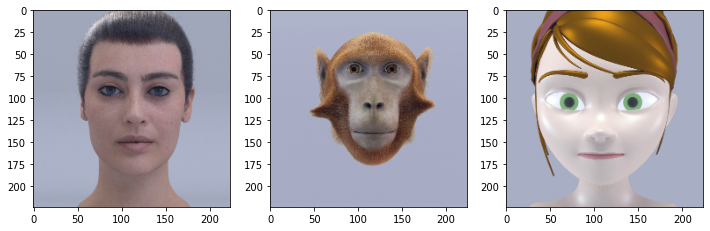

In [6]:
plot_images(data)

# predict with extraction pipeline

In [7]:
def predict_v4(data):
    # predict v4 output
    preds = v4_model.predict(data[0], verbose=1)
    print("[predict_v4] shape prediction", np.shape(preds))

    # get feature maps that mimic a semantic selection pipeline
    # keep only highest IoU semantic score
    eyebrow_preds = preds[..., best_eyes_IoU_ft]
    print("[predict_v4] shape eyebrow semantic feature selection", np.shape(eyebrow_preds))
    lips_preds = preds[..., best_nose_IoU_ft]
    print("[predict_v4] shape lips semantic feature selection", np.shape(lips_preds))
    preds = np.concatenate((eyebrow_preds, lips_preds), axis=3)
    print("[predict_v4] shape preds", np.shape(preds))

    return preds

In [8]:
preds = predict_v4(data)

1/1 [==============================] - 0s 87ms/step
[predict_v4] shape prediction (3, 56, 56, 256)
[predict_v4] shape eyebrow semantic feature selection (3, 56, 56, 7)
[predict_v4] shape lips semantic feature selection (3, 56, 56, 61)
[predict_v4] shape preds (3, 56, 56, 68)


2022-07-18 09:01:42.690782: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2022-07-18 09:01:42.738425: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


# build RBF

In [9]:
 # louise
rbf_template_hum = np.array([[[21, 25], [20, 25]], [[21, 25], [33, 38]], [[28, 36], [26, 32]]])
config['rbf_sigma'] = [10300, 10200, 8000]
patterns_hum = PatternFeatureSelection(config, template=rbf_template_hum)
# Monkey
rbf_template_monk = np.array([[[14, 19], [18, 25]], [[14, 19], [33, 40]], [[23, 31], [26, 32]]])
config['rbf_sigma'] = [13150, 13100, 9000]
patterns_monk = PatternFeatureSelection(config, template=rbf_template_monk)
# Merry
rbf_template_cart = np.array([[[24, 27], [16, 21]], [[24, 27], [34, 39]], [[33, 41], [24, 30]]])
config['rbf_sigma'] = [8500, 8500, 8200]
patterns_cart = PatternFeatureSelection(config, template=rbf_template_cart)

rbf_templates = [rbf_template_hum, rbf_template_monk, rbf_template_cart]
patterns = [patterns_hum, patterns_monk, patterns_cart]

shape img_norm (56, 56, 3)
shape img_norm (56, 56, 3)
shape img_norm (56, 56, 3)


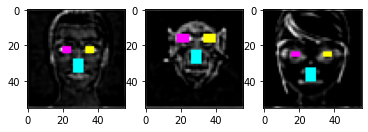

In [10]:
# show RBF on face
plt.figure()
for i in range(3):
    img = preds[i, ..., 0]
    img_norm = img / np.amax(img)
    img_norm = np.repeat(np.expand_dims(img_norm, axis=2), 3, axis=2)
    print("shape img_norm", np.shape(img_norm))

    img_norm[rbf_templates[i][0, 0, 0]:rbf_templates[i][0, 0, 1], rbf_templates[i][0, 1, 0]:rbf_templates[i][0, 1, 1]] = [1, 0, 1]
    img_norm[rbf_templates[i][1, 0, 0]:rbf_templates[i][1, 0, 1], rbf_templates[i][1, 1, 0]:rbf_templates[i][1, 1, 1]] = [1, 1, 0]
    img_norm[rbf_templates[i][2, 0, 0]:rbf_templates[i][2, 0, 1], rbf_templates[i][2, 1, 0]:rbf_templates[i][2, 1, 1]] = [0, 1, 1]

    plt.subplot(1, 3, i + 1)
    plt.imshow(img_norm, cmap='viridis')

# fit template

In [11]:
# fit templates
templates = []
for i in range(3):
    # template = patterns.fit(mask_template)
    _preds = np.expand_dims(preds[i], axis=0)
    template_preds = np.repeat(np.expand_dims(_preds, axis=0), len(rbf_templates[i]), axis=0)
    print("shape template preds", np.shape(template_preds))
    template = patterns[i].fit(template_preds)
    template[template < 0.25] = 0
    print("shape template", np.shape(template), np.amin(template), np.amax(template))
    templates.append(template)
print("shape templates", np.shape(templates))
templates = np.concatenate((templates[0], templates[1], templates[2]), axis=3)
print("shape templates", np.shape(templates))

shape template preds (3, 1, 56, 56, 68)
[PATTERN] Fit pattern
shape template (1, 56, 56, 3) 0.0 1.0
shape template preds (3, 1, 56, 56, 68)
[PATTERN] Fit pattern
shape template (1, 56, 56, 3) 0.0 1.0
shape template preds (3, 1, 56, 56, 68)
[PATTERN] Fit pattern
shape template (1, 56, 56, 3) 0.0 1.0
shape templates (3, 1, 56, 56, 3)
shape templates (1, 56, 56, 9)


0 min max 0.0 1.0
1 min max 0.0 1.0
2 min max 0.0 1.0
3 min max 0.0 1.0
4 min max 0.0 1.0
5 min max 0.0 1.0
6 min max 0.0 1.0
7 min max 0.0 1.0
8 min max 0.0 1.0


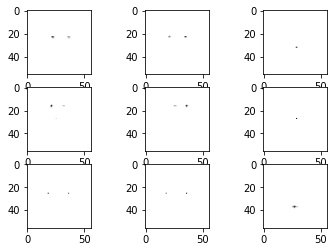

In [12]:
# plot template
plt.figure()
for i in range(3):
    for j in range(3):
        plt.subplot(3, 3, i * 3 + j + 1)
        _template = templates[0, ..., i * 3 + j]
        print(i * 3 + j, "min max", np.amin(_template), np.amax(_template))
        plt.imshow(_template, cmap='Greys')

# get patches

In [13]:
# test function pred_to_patch
patches = pred_to_patch(templates[0, ..., 0])
print("shape patches", np.shape(patches))

shape patches (1, 7, 7, 64)


In [14]:
# test function get_patches_centers
centers, max_patch = get_patches_centers(patches)
print("shape centers", np.shape(centers))
print("max_patch", max_patch)

shape centers (4, 2)
max_patch [1.0, 0.5933718608612403, 0.30945918980134685, 0.26870545363696435]


# Get activity from patches

max template pattern 0: [1. 1. 1.]
max template pattern 1: [0.    0.275 0.   ]
max template pattern 2: [0. 0. 0.]
max template pattern 0: [0.254 0.255 0.   ]
max template pattern 1: [1. 1. 1.]
max template pattern 2: [0. 0. 0.]
max template pattern 0: [0. 0. 0.]
max template pattern 1: [0. 0. 0.]
max template pattern 2: [1. 1. 1.]


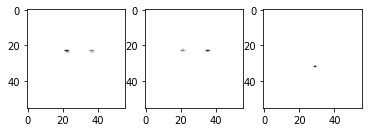

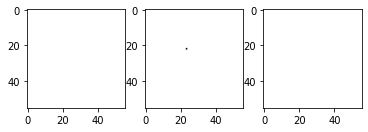

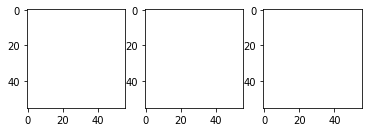

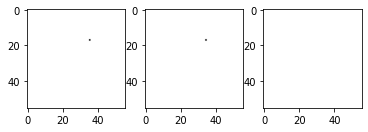

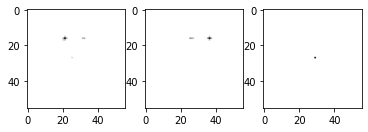

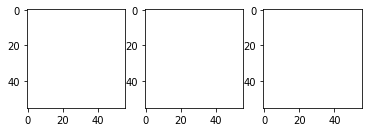

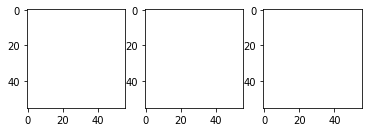

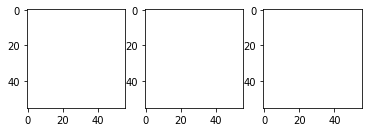

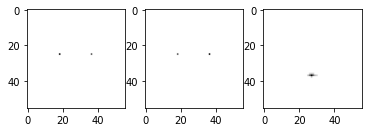

In [15]:
activities_dict = []
for i in range(3):
    activity_dict = get_activity_from_patterns(preds[i], patterns, rbf_templates, verbose=True, do_plot=True)
    activities_dict.append(activity_dict)

In [16]:
def get_pos_from_dict(dict, ratio=None):
    pos = []
    for i in dict:
        pos.append(dict[i]["pos"])

    pos = np.array(pos)

    if ratio is not None:
        pos = np.round(pos * ratio).astype(int)

    return pos

In [17]:
def get_lmk_colors(dict):
    colors = []
    for i in dict:
        if dict[i]["type"] in [0, 3, 6]:
            colors.append([1, 0, 0])
        elif dict[i]["type"] in [1, 4, 7]:
            colors.append([1, 1, 0])
        elif dict[i]["type"] in [2, 5, 8]:
            colors.append([0, 1, 1])
        else:
            print("[get_lmk_colors] type {} not found!".format(dict[i]["type"]))
            colors.append([1, 1, 1])

    return colors

In [47]:
# display activities
for i in range(3):
    activity_dict = activities_dict[i]
    for a in activity_dict:
        print(a, activity_dict[a])
    print()

0 {'type': 0, 'pos': [22.003262655858926, 22.999979621279522], 'max': 1.0}
1 {'type': 0, 'pos': [36.039804202291094, 22.999968607412693], 'max': 0.5933718608612403}
2 {'type': 0, 'pos': [22.51326403401181, 24.0], 'max': 0.30945918980134685}
3 {'type': 0, 'pos': [36.48491038242399, 24.0], 'max': 0.26870545363696435}
4 {'type': 1, 'pos': [20.93469826547703, 22.843460385313954], 'max': 0.5893314035700925}
5 {'type': 1, 'pos': [34.99158916358057, 22.999979295172622], 'max': 1.0}
6 {'type': 2, 'pos': [28.97691162181664, 32.0], 'max': 1.0}
7 {'type': 4, 'pos': [22.999837049795563, 21.999860328396196], 'max': 0.2749242154896316}

0 {'type': 0, 'pos': [34.99992447012733, 16.99997482337578], 'max': 0.25419765625940793}
1 {'type': 1, 'pos': [33.999949788158816, 16.999974894079408], 'max': 0.2549135491032791}
2 {'type': 3, 'pos': [20.99990670343077, 14.999869384803079], 'max': 0.3429858478861965}
3 {'type': 3, 'pos': [20.885799588867044, 16.246051447119303], 'max': 1.0}
4 {'type': 3, 'pos': [30.9

In [19]:
activities_dict_max_pooled = []
for i in range(3):
    activity_dict = max_pool_patches_activity(activities_dict[i])
    activities_dict_max_pooled.append(activity_dict)

In [20]:
# display activities
for i in range(3):
    activity_dict = activities_dict_max_pooled[i]
    for a in activity_dict:
        print(activity_dict[a])
    print()

{'type': 0, 'pos': [22.003262655858926, 22.999979621279522], 'max': 1.0}
{'type': 1, 'pos': [34.99158916358057, 22.999979295172622], 'max': 1.0}
{'type': 2, 'pos': [28.97691162181664, 32.0], 'max': 1.0}

{'type': 3, 'pos': [20.885799588867044, 16.246051447119303], 'max': 1.0}
{'type': 4, 'pos': [35.997630603567885, 16.142617837993775], 'max': 1.0}
{'type': 5, 'pos': [28.9999680002048, 26.999980800122877], 'max': 1.0}

{'type': 6, 'pos': [17.999987200081918, 24.99999360004096], 'max': 1.0}
{'type': 7, 'pos': [35.999974400163836, 24.99999360004096], 'max': 1.0}
{'type': 8, 'pos': [27.204542116150083, 36.87356631391144], 'max': 1.0}



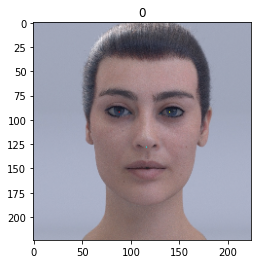

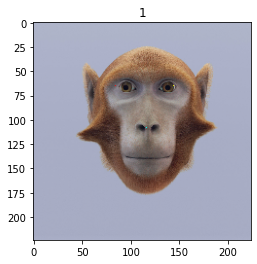

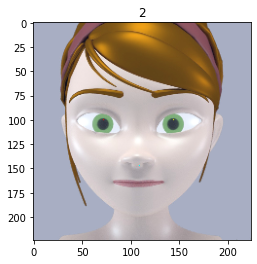

In [21]:
# print landmarks
for i in range(3):
    pos = get_pos_from_dict(activities_dict_max_pooled[i], ratio=224/56)
    lmk_color = get_lmk_colors(activities_dict_max_pooled[i])
    plot_images([[data[0][i]]], lmk_pos=pos, lmk_colors=lmk_color, title=str(i))

# Get Type from activity

In [22]:
def get_type(activity_dict, verbose=False):
    """
    max pool the types of the dictionary to get the face type
    """
    types = [0, 0, 0]  # hum_type, monk_type, cart_type

    for i in activity_dict:
        if verbose:
            print(activity_dict[i])
        dict = activity_dict[i]

        # count types
        if dict['type'] in [0, 1, 2]:
            types[0] += 1 * activity_dict[i]["max"]
        elif dict['type'] in [3, 4, 5]:
            types[1] += 1 * activity_dict[i]["max"]
        elif dict['type'] in [6, 7, 8]:
            types[2] += 1 * activity_dict[i]["max"]

    if verbose:
        print("types:", types)

    bfs_type = np.argmax(types)

    return bfs_type

In [23]:
types = ["human", "monkey", "cartoon"]
bfs_types = []
for i in range(3):
    bfs_type = get_type(activities_dict_max_pooled[i])
    bfs_types.append(bfs_type)
    print("type:", types[bfs_type])

type: human
type: monkey
type: cartoon


# Apply "graph" (infer face structure from a reference structure)

In [24]:
ref_struct = activities_dict_max_pooled
face_structures = []
for i in range(3):
    face_dict = get_face_structure(activities_dict_max_pooled[i], ref_struct[bfs_types[i]])
    face_structures.append(face_dict)
    print("face_dict:", face_dict)
    print()

face_dict: {0: {'type': 0, 'pos': [22.003262655858926, 22.999979621279522], 'max': 1.0}, 1: {'type': 1, 'pos': [34.99158916358057, 22.999979295172622], 'max': 1.0}, 2: {'type': 2, 'pos': [28.97691162181664, 32.0], 'max': 1.0}}

face_dict: {0: {'type': 3, 'pos': [20.885799588867044, 16.246051447119303], 'max': 1.0}, 1: {'type': 4, 'pos': [35.997630603567885, 16.142617837993775], 'max': 1.0}, 2: {'type': 5, 'pos': [28.9999680002048, 26.999980800122877], 'max': 1.0}}

face_dict: {0: {'type': 6, 'pos': [17.999987200081918, 24.99999360004096], 'max': 1.0}, 1: {'type': 7, 'pos': [35.999974400163836, 24.99999360004096], 'max': 1.0}, 2: {'type': 8, 'pos': [27.204542116150083, 36.87356631391144], 'max': 1.0}}



# get face attributes (positions, types, scales)

In [25]:
def get_face_pos(activity_dict, verbose=False):
    positions = []

    for i in activity_dict:
        dict = activity_dict[i]

        # get positions of types
        if dict['type'] in [0, 3, 6]:
            right_eye_pos = dict['pos']
        elif dict['type'] in [1, 4, 7]:
            left_eye_pos = dict['pos']
        elif dict['type'] in [2, 5, 8]:
            nose_pos = dict['pos']

        positions.append(dict['pos'])

        if verbose:
            print("positions")
            print(positions)

    mean_pos = np.mean(positions, axis=0)
    width = np.abs(left_eye_pos[0] - right_eye_pos[0])
    height = nose_pos[1] - np.amin([left_eye_pos[1], right_eye_pos[1]])

    return mean_pos, [width, height]

In [26]:
positions = []
sizes = []
for i in range(3):
    pos, size = get_face_pos(face_structures[i])
    positions.append(pos)
    sizes.append(size)
    print("pos:", pos)
    print("size:", size)
    print()

pos: [28.657 26.   ]
size: [12.988326507721645, 9.000020704827378]

pos: [28.628 19.796]
size: [15.11183101470084, 10.857362962129102]

pos: [27.068 28.958]
size: [17.999987200081918, 11.87357271387048]



# predict on test set

In [27]:
def predict_face_attributes(preds, patterns, rbf_templates, ref_struct, verbose=False):
    activity_dict = get_activity_from_patterns(preds, patterns, rbf_templates)
    activities_dict_max_pooled = max_pool_patches_activity(activity_dict)

    bfs_type = get_type(activity_dict)
    face_dict = get_face_structure(activities_dict_max_pooled, ref_struct[bfs_type])
    pos, size = get_face_pos(face_dict)

    if verbose:
        print("pos:", pos)
        print("size:", size)
        print()

    return [bfs_type, pos, size]

In [28]:
for i in range(3):
    attributes = predict_face_attributes(preds[i], patterns, rbf_templates, ref_struct)
    print("type:", attributes[0])
    print("pos:", attributes[1])
    print("size:", attributes[2])
    print()

type: 0
pos: [28.657 26.   ]
size: [12.988326507721645, 9.000020704827378]

type: 1
pos: [28.628 19.796]
size: [15.11183101470084, 10.857362962129102]

type: 2
pos: [27.068 28.958]
size: [17.999987200081918, 11.87357271387048]



In [29]:
# get all reference identities
test_data = load_data(config, train=False)
print("shape test data", np.shape(test_data[0]))

/Users/michaelstettler/PycharmProjects/BVS/BVS/utils/load_data.py:426: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df = new_df.append(sub_df, ignore_index=True)
100%|██████████| 12/12 [00:00<00:00, 165.75it/s]

shape test data (12, 224, 224, 3)


In [30]:
# predict v4 output
test_preds = predict_v4(test_data)

1/1 [==============================] - 0s 31ms/step
[predict_v4] shape prediction (12, 56, 56, 256)
[predict_v4] shape eyebrow semantic feature selection (12, 56, 56, 7)
[predict_v4] shape lips semantic feature selection (12, 56, 56, 61)
[predict_v4] shape preds (12, 56, 56, 68)


In [31]:
id_params = []
for p, pred in enumerate(test_preds):
    id_param = predict_face_attributes(pred, patterns, rbf_templates, ref_struct)
    id_params.append(id_param)

[INFER_NOSE] TODO infer nose better!, so far simply return the prior since it is a the center of both eyes as the dataset is super simple...


In [32]:
for id_param in id_params:
    print(id_param)

[0, array([28.063, 26.   ]), [10.35779844698207, 9.000035706204308]]
[0, array([28.312, 26.   ]), [11.769609767315998, 9.00002317246052]]
[0, array([28.856, 25.969]), [14.240456393471895, 9.092130888873847]]
[0, array([29.045, 25.972]), [15.478335385881724, 9.08353658961887]]
[1, array([28.478, 19.782]), [12.328176830093383, 10.833050053720797]]
[1, array([28.539, 19.823]), [13.554391931618945, 10.834565227121765]]
[1, array([28.719, 19.797]), [16.61691403857055, 10.8610899951419]]
[1, array([28.797, 19.787]), [17.755034834086466, 10.889308574593326]]
[2, array([27.001, 28.965]), [14.000026457722786, 11.894619904876333]]
[2, array([27.06 , 28.955]), [16.000001272795824, 11.865567979494315]]
[2, array([27.094, 28.98 ]), [19.9999727278862, 11.938579870177922]]
[2, array([27.213, 28.98 ]), [21.679967336041397, 11.941066724460722]]


# get identity

In [33]:
# compute ratio, since this is the identity parameter!
for id_param in id_params:
    ref_size = sizes[id_param[0]]
    ratio = id_param[2][0] / ref_size[0]

    print("ratio:", ratio)

ratio: 0.7974698234467921
ratio: 0.9061683012294839
ratio: 1.0964042507713254
ratio: 1.1917112937282377
ratio: 0.8157963663106405
ratio: 0.8969390882172509
ratio: 1.0995963376248423
ratio: 1.1749095670017953
ratio: 0.7777798007355845
ratio: 0.8888895916949879
ratio: 1.1111103861115623
ratio: 1.204443486267742


## Test templates on all facial expressions

In [34]:
config["val_expression"] = ["full"]
test_fer_data = load_data(config, train=False)
print("[LOAD] test_fer_data loaded", np.shape(test_fer_data[0]))

/Users/michaelstettler/PycharmProjects/BVS/BVS/utils/load_data.py:426: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df = new_df.append(sub_df, ignore_index=True)
100%|██████████| 84/84 [00:00<00:00, 163.99it/s]

[LOAD] test_fer_data loaded (84, 224, 224, 3)


In [35]:
# plot_images(test_fer_data)

In [36]:
# predict v4 output
test_fr_preds = predict_v4(test_fer_data)
print("shape test_fr_preds", np.shape(test_fr_preds))

3/3 [==============================] - 0s 180ms/step
[predict_v4] shape prediction (84, 56, 56, 256)
[predict_v4] shape eyebrow semantic feature selection (84, 56, 56, 7)
[predict_v4] shape lips semantic feature selection (84, 56, 56, 61)
[predict_v4] shape preds (84, 56, 56, 68)
shape test_fr_preds (84, 56, 56, 68)


In [37]:
# get_activity_from_patterns(test_fr_preds[3], patterns, rbf_templates, threshold_val=0.20, do_plot=True)

In [38]:
def check_unpooled_lmk(data, preds, verbose=False, do_plot=False):
    activities_dict = []
    #for i in range(np.shape(test_fer_preds)[0]):
    for i in range(len(preds)):
        if verbose:
            print("pred:", i)

        activity_dict = get_activity_from_patterns(preds[i], patterns, rbf_templates, threshold_val=0.2)
        activities_dict.append(activity_dict)

        if verbose:
            for a in activity_dict:
                print("{}:".format(a), activity_dict[a])
            print()

        if do_plot:
            # plot lmk on image
            pos = get_pos_from_dict(activity_dict, ratio=224/56)
            lmk_color = get_lmk_colors(activity_dict)
            plot_images([[data[0][i]]], lmk_pos=pos, lmk_colors=lmk_color, title=str(i))

    return activities_dict

In [39]:
# # Louise
# idx = np.arange(28)
# # Monkey
# idx = np.arange(28, 56)
# # Merry
# idx = np.arange(56, 84)
# all
idx = np.arange(84)
test_fer_data_print = [test_fer_data[0][idx], test_fer_data[1][idx]]
fr_lmk = check_unpooled_lmk(test_fer_data_print, test_fr_preds[idx], verbose=False, do_plot=False)

In [40]:
def check_pooled_lmk(data, activities_dict, verbose=False, do_plot=False):
    max_pooled_activities_dict = []

    for i in range(len(activities_dict)):
        activity_dict = max_pool_patches_activity(activities_dict[i])
        max_pooled_activities_dict.append(activity_dict)

        if verbose:
            print("pred:", i)
            for a in activity_dict:
                print(activity_dict[a])
            print()

        if do_plot:
            # plot lmk on image
            pos = get_pos_from_dict(activity_dict, ratio=224/56)
            lmk_color = get_lmk_colors(activity_dict)
            plot_images([[data[0][i]]], lmk_pos=pos, lmk_colors=lmk_color, title=str(i))

    return max_pooled_activities_dict

In [41]:
fr_lmk_pooled = check_pooled_lmk(test_fer_data_print, fr_lmk, verbose=False, do_plot=False)

In [45]:
def check_structure_face(data, activities_dict, ref_struct, verbose=False, do_plot=False):
    scales = []
    for i in range(len(activities_dict)):
        if verbose:
            print("i", i)
        bfs_type = get_type(activities_dict[i])
        face_dict = get_face_structure(activities_dict[i], ref_struct[bfs_type], verbose=verbose)
        pos, size = get_face_pos(face_dict)

        # compute scale ratio
        ref_dist_eye = ref_struct[bfs_type][1]["pos"][0] - ref_struct[bfs_type][0]["pos"][0]
        scale = size[0] / ref_dist_eye
        scales.append(scale)

        if do_plot:
            # plot lmk on image
            pos = get_pos_from_dict(face_dict, ratio=224/56)
            lmk_color = get_lmk_colors(face_dict)
            plot_images([[data[0][i]]], lmk_pos=pos, lmk_colors=lmk_color, title="{} {:.2f}".format(i, size[0] / ref_dist_eye))

        if verbose:
            print("Structure face_dict:", face_dict)
            print("Scale: {}. (width: {}, ref_dist_eye: {})".format(ref_dist_eye, size[0], ref_dist_eye))
            print()

    return scales

In [49]:
scales = check_structure_face(test_fer_data_print, fr_lmk_pooled, ref_struct, verbose=False, do_plot=False)

# print all scales
for s, scale in enumerate(scales):
    print(s, scale, np.round(scale, decimals=1))
    if s != 0 and (s + 1) % 7 == 0:
        print()

[INFER_NOSE] TODO infer nose better!, so far simply return the prior since it is a the center of both eyes as the dataset is super simple...
[INFER_NOSE] TODO infer nose better!, so far simply return the prior since it is a the center of both eyes as the dataset is super simple...
[INFER_NOSE] TODO infer nose better!, so far simply return the prior since it is a the center of both eyes as the dataset is super simple...
[INFER_NOSE] TODO infer nose better!, so far simply return the prior since it is a the center of both eyes as the dataset is super simple...
[INFER_NOSE] TODO infer nose better!, so far simply return the prior since it is a the center of both eyes as the dataset is super simple...
[INFER_NOSE] TODO infer nose better!, so far simply return the prior since it is a the center of both eyes as the dataset is super simple...
[INFER_NOSE] TODO infer nose better!, so far simply return the prior since it is a the center of both eyes as the dataset is super simple...
[INFER_NOSE] 